# Ejecución de estrategia de manera simple con la última actualización de manera local sin testnet.

<function matplotlib.pyplot.show(close=None, block=None)>

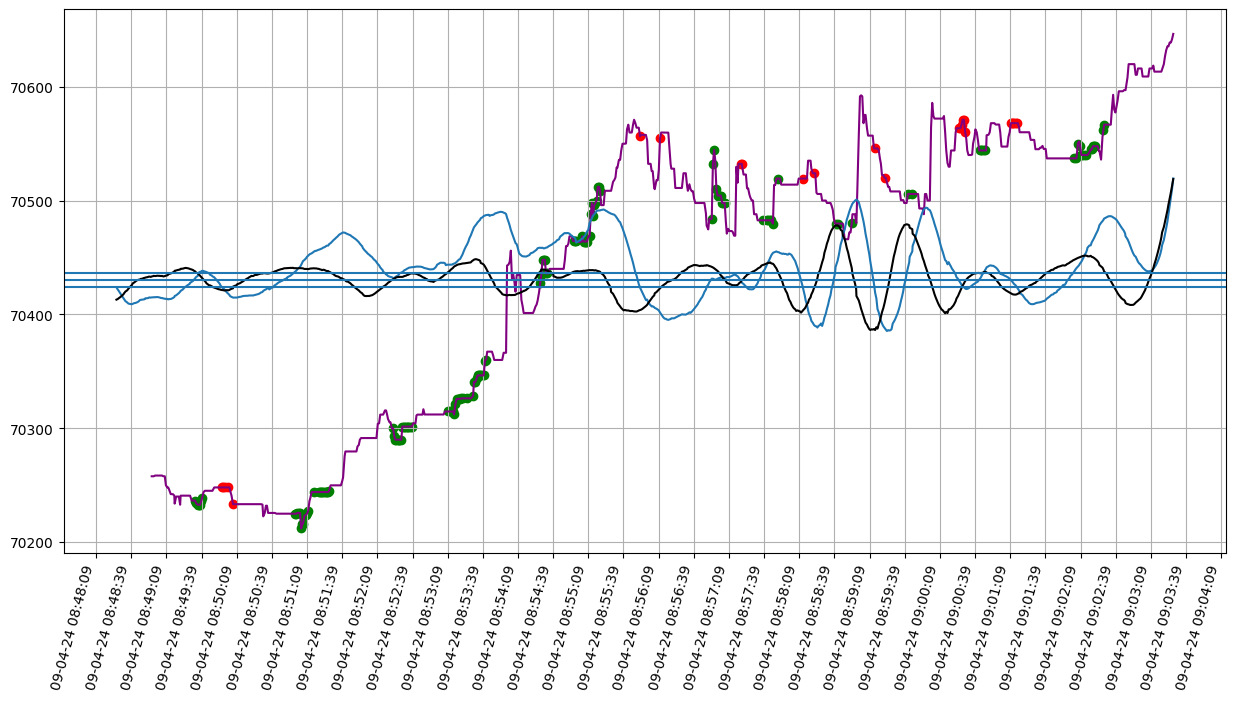

In [25]:
################################################################################################################################################################################
# Importamos las librerías necesarias y generamos conexión con Binance para descargar la lista de pares que binance maneja.
################################################################################################################################################################################
import pandas as pd
import os
import numpy as np
from datetime import datetime
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from binance import Client

client = Client()

##################################################
# Lista de parámetros.
##################################################
# Parámetros de interpolación.
###################################
smooth_interval = 60
smooth_exp = 3
###################################
# Parámetros de estrategia.
###################################
rango = 30
std_mult = 50
z_aprox = 0.009


##################################################################################################################################
# Descarga y limpieza de datos de 5 días en adelante
##################################################################################################################################
recent_data = pd.read_csv('../csvs/streaming/BTCUSDT.csv',skiprows=31000)
recent_data.columns = ['Tiempo','Par','Precio']
recent_data['Tiempo'] = recent_data.Tiempo.astype('datetime64')
recent_data = recent_data.set_index('Tiempo')
recent_data['Precio'] = recent_data.Precio.astype('Float32')
recent_data = recent_data.reset_index()

##################################################
# Interpolación (suavizado)  del Precio (OPEN) con SciPy y obtención de derivadas con su respectiva interpolación.
##################################################
recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Precio,smooth_interval,smooth_exp)
recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,smooth_interval,smooth_exp)
recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,smooth_interval,smooth_exp)
recent_data['Tercer_Derivada'] = recent_data.SD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['TD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Tercer_Derivada,smooth_interval,3)

######################################################################
# Agregamos el código necesario para encontrar los puntos exactos mínimos y máximos
######################################################################
initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-60*15:-60*15 + 1].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() + rango
final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() - rango
mp = recent_data.Precio[initial_date_index:final_date_index].mean()

# initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[60*30:60*30 + 1].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() + rango
# final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[60*80:60*80 + 1].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() - rango

lista_min_max = recent_data[initial_date_index:final_date_index][(recent_data[initial_date_index:final_date_index]['TD_Interpolacion'] >= -z_aprox) & (recent_data[initial_date_index:final_date_index]['TD_Interpolacion'] <= z_aprox)]
indices_min_max = lista_min_max.index.tolist()

max_points_idx = []
min_points_idx = []
pmin = 0
pmax = 0

for PMSD in indices_min_max:
    if (recent_data.SD_Interpolacion[PMSD:PMSD+1].item() > 0) & (recent_data.PD_Interpolacion[PMSD:PMSD+1].item() > 0):
        pmax_idx = PMSD
        if ((mp + recent_data.SD_Interpolacion[PMSD]*250) > (mp + np.std(recent_data.SD_Interpolacion)*std_mult)) & ((mp + recent_data.PD_Interpolacion[PMSD]*25) > (mp + np.std(recent_data.SD_Interpolacion)*std_mult)):
            pmax = recent_data.SD_Interpolacion[PMSD]
        for i in range(rango+1):
            if ((recent_data.SD_Interpolacion[PMSD-i] > pmax)) & ((mp + recent_data.SD_Interpolacion[PMSD-i]*250) > (mp + np.std(recent_data.SD_Interpolacion)*std_mult)) & ((mp + recent_data.PD_Interpolacion[PMSD-i]*25) > (mp + np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmax_idx = PMSD-i
            elif ((recent_data.SD_Interpolacion[PMSD+i] > pmax)) & ((mp + recent_data.SD_Interpolacion[PMSD+i]*250) > (mp + np.std(recent_data.SD_Interpolacion)*std_mult)) & ((mp + recent_data.PD_Interpolacion[PMSD+i]*25) > (mp + np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmax_idx = PMSD+i
        try:
            max_points_idx.append(pmax_idx)
        except:
            pass
    elif (recent_data.SD_Interpolacion[PMSD:PMSD+1].item() < 0) & (recent_data.PD_Interpolacion[PMSD:PMSD+1].item() < 0):
        pmin_idx = PMSD
        if ((mp + recent_data.SD_Interpolacion[PMSD]*250) < (mp - np.std(recent_data.SD_Interpolacion)*std_mult)) & ((mp + recent_data.PD_Interpolacion[PMSD]*25) < (mp - np.std(recent_data.SD_Interpolacion)*std_mult)):
            pmin = recent_data.SD_Interpolacion[PMSD]
        for i in range(rango+1):
            if ((recent_data.SD_Interpolacion[PMSD-i] < pmin)) & ((mp + recent_data.SD_Interpolacion[PMSD-i]*250) < (mp - np.std(recent_data.SD_Interpolacion)*std_mult)) & ((mp + recent_data.PD_Interpolacion[PMSD-i]*25) < (mp - np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmin_idx = PMSD-i
            elif ((recent_data.SD_Interpolacion[PMSD+i] < pmin)) & ((mp + recent_data.SD_Interpolacion[PMSD+i]*250) < (mp - np.std(recent_data.SD_Interpolacion)*std_mult)) & ((mp + recent_data.PD_Interpolacion[PMSD+i]*25) < (mp - np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmin_idx = PMSD+i
        try:
            min_points_idx.append(pmin_idx)
        except:
            pass
max_points_idx = list(set(max_points_idx))
min_points_idx = list(set(min_points_idx))
max_points_idx.sort()
min_points_idx.sort()
# close_points_max = []
# close_points_min = []
# for lista in [max_points_idx,min_points_idx]:
#     for i in range(len(lista)-1):
#         if lista[i+1]-lista[i] == 1:
#             if lista == max_points_idx:
#                 close_points_max.append(i+1)
#             else:
#                 close_points_min.append(i+1)
#     if lista == max_points_idx:
#         for idx in sorted(close_points_max,reverse=True):
#             del lista[idx]
#     else:
#         for idx in sorted(close_points_min,reverse=True):
#             del lista[idx]


##################################################################################################################################
# Gráfica final del backtesting sobre nuestro análisis con puntos de compra y venta.
##################################################################################################################################

plt.figure(figsize=(15,8))
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index + rango],recent_data.Precio[initial_date_index:final_date_index + rango].multiply(1),color='purple')
# plt.plot(recent_data.Tiempo[initial_date_index-rango:final_date_index],recent_data.Interpolacion[initial_date_index-rango:final_date_index].multiply(1),color='red')
plt.plot(recent_data.Tiempo[initial_date_index-rango:final_date_index  + rango],recent_data.PD_Interpolacion[initial_date_index-rango:final_date_index + rango].multiply(25)+mp)
plt.plot(recent_data.Tiempo[initial_date_index-rango:final_date_index  + rango],recent_data.SD_Interpolacion[initial_date_index-rango:final_date_index + rango].multiply(250)+mp,color='k')
plt.scatter(recent_data.Tiempo.iloc[max_points_idx],recent_data.Precio.iloc[max_points_idx],color='g')
plt.scatter(recent_data.Tiempo.iloc[min_points_idx],recent_data.Precio.iloc[min_points_idx],color='r')
plt.grid(visible=True)

# Set minor tick locations.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.SecondLocator(interval=30))
# plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gcf().autofmt_xdate()
# Set grid to use minor tick locations. 
plt.grid(which = 'minor')
plt.xticks(rotation=75)
plt.axhline(mp)
plt.axhline(np.std(recent_data.dropna().SD_Interpolacion)*std_mult + mp)
plt.axhline(mp - np.std(recent_data.dropna().SD_Interpolacion)*std_mult)
plt.show

In [26]:
pmax_df = recent_data.iloc[max_points_idx].loc[:,['Tiempo','Precio']]
pmax_df['Accion'] = 'C'
pmin_df = recent_data.iloc[min_points_idx].loc[:,['Tiempo','Precio']]
pmin_df['Accion'] = 'V'
vc_df = pd.concat([pmax_df,pmin_df],axis=0)
vc_df = vc_df.reset_index()
vc_df = vc_df.set_index('index')
vc_df = vc_df.sort_index()
del_idx = []
# vc_df = vc_df.reset_index()
for i in vc_df.index:
    try:
        if vc_df.Accion[i+1] == vc_df.Accion[i]:
            del_idx.append(i+1)
    except:
        pass
vc_df.drop(del_idx,inplace=True)
vc_df = vc_df.reset_index(drop=True)
vc_df['Diferencia_Precio_USDT'] = pd.Series(dtype='float')
for i in range(len(vc_df)-1):
    vc_df['Diferencia_Precio_USDT'][i+1] = (vc_df.Precio[i+1] - vc_df.Precio[i])
profits = 0
for i in range(len(vc_df)-1):
    if vc_df.Accion[i] == 'C' and vc_df.Diferencia_Precio_USDT[i+1] > 0:
        profits += vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'C' and vc_df.Diferencia_Precio_USDT[i+1] < 0:
        profits -= vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'V' and vc_df.Diferencia_Precio_USDT[i+1] > 0:
        profits += vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'V' and vc_df.Diferencia_Precio_USDT[i+1] < 0:
        profits -= vc_df.Diferencia_Precio_USDT[i+1]
profits

C:\Users\tinma\AppData\Local\Temp\ipykernel_35696\1571396145.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vc_df['Diferencia_Precio_USDT'][i+1] = (vc_df.Precio[i+1] - vc_df.Precio[i])


900.90625

C:\Users\tinma\AppData\Local\Temp\ipykernel_38980\3124231378.py:67: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() - rango
C:\Users\tinma\AppData\Local\Temp\ipykernel_38980\3124231378.py:74: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  mp = recent_data.Precio[initial_date_index:final_date_index].mean()
C:\Users\tinma\AppData\Local\Temp\i

<function matplotlib.pyplot.show(close=None, block=None)>

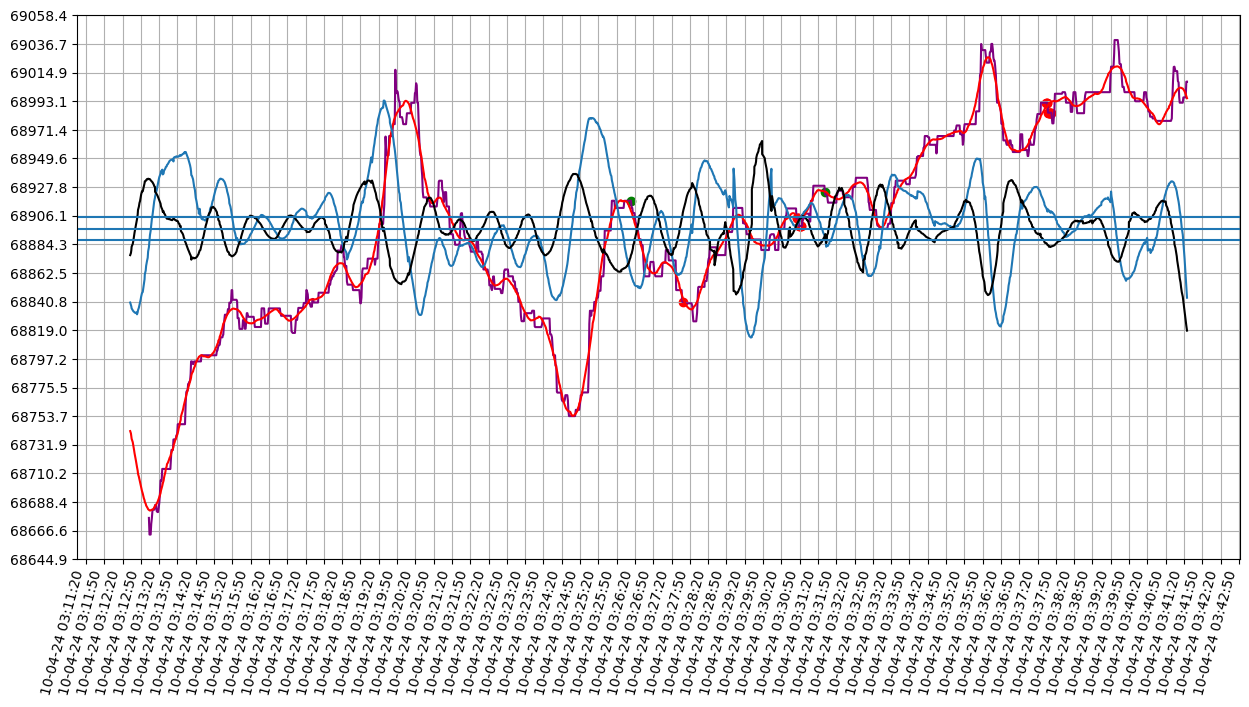

In [45]:
################################################################################################################################################################################
# Importamos las librerías necesarias y generamos conexión con Binance para descargar la lista de pares que binance maneja.
################################################################################################################################################################################
import pandas as pd
import os
import numpy as np
from datetime import datetime
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from binance import Client

client = Client()

##################################################
# Lista de parámetros.
##################################################
# Parámetros de interpolación.
###################################
smooth_interval = 60
smooth_exp = 3
###################################
# Parámetros de estrategia.
###################################
rango = 30
std_mult = 85
pdi_mult = 25
sdi_mult = 250
z_aprox = 0.0009

max_points_idx = []
min_points_idx = []

##################################################################################################################################
# Descarga y limpieza de datos de 5 días en adelante
##################################################################################################################################
# recent_data = pd.read_csv('../../csvs/streaming/BTCUSDT.csv')
# recent_data.columns = ['Tiempo','Par','Precio']
# recent_data['Tiempo'] = recent_data.Tiempo.astype('datetime64')
# recent_data = recent_data.set_index('Tiempo')
# recent_data['Precio'] = recent_data.Precio.astype(float)
# recent_data = recent_data.reset_index()

recent_data = pd.DataFrame(client.get_historical_klines('BTCUSDT','1m','2 hours ago UTC'))
recent_data = recent_data.iloc[:,:2]
recent_data.columns = ['Tiempo','Precio']
recent_data['Tiempo'] = pd.to_datetime(recent_data.Tiempo,unit='ms')
recent_data = recent_data.set_index('Tiempo')
recent_data = recent_data.astype(float)
recent_data = recent_data.reset_index()

##################################################
# Interpolación (suavizado)  del Precio (OPEN) con SciPy y obtención de derivadas con su respectiva interpolación.
##################################################
recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Precio,smooth_interval,smooth_exp)
recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,smooth_interval,smooth_exp)
recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,smooth_interval,smooth_exp)
recent_data['Tercer_Derivada'] = recent_data.SD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['TD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Tercer_Derivada,smooth_interval,3)
# recent_data = recent_data.dropna()


######################################################################
# Agregamos el código necesario para encontrar los puntos exactos mínimos y máximos
######################################################################
try:
    initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo.iloc[:1].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() + rango
except:
    initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo.iloc[:1].item()),'%Y-%m-%d %H:%M:%S')].index.item() + rango
try:
    final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() - rango
except:
    final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S')].index.item() - rango

lista_min_max = recent_data[initial_date_index:final_date_index][(recent_data[initial_date_index:final_date_index]['TD_Interpolacion'] >= -z_aprox) & (recent_data[initial_date_index:final_date_index]['TD_Interpolacion'] <= z_aprox)]
indices_min_max = lista_min_max.index.tolist()
mp = recent_data.Precio[initial_date_index:final_date_index].mean()

pmin = 0
pmax = 0

# for PMSD in indices_min_max:
#     if PMSD > len(recent_data) - rango:
#         break
#     if (sdi_mid.item() > 0) & (pdi_mid > 0):
#         pmax_idx = PMSD
#         if ((sdi_mid*sdi_mult) > (lim_std*std_mult)) & ((pdi_mid*pdi_mult) > (lim_std*std_mult)):
#             pmax = recent_data.SD_Interpolacion[PMSD]
#         for i in range(rango+1):
#             if ((sdi_back > pmax)) & (sdi_back*sdi_mult) > (lim_std*std_mult)) & ((mp + recent_data.PD_Interpolacion[PMSD-i]*pdi_mult) > (mp + np.std(recent_data.SD_Interpolacion)*std_mult)):
#                 pmax_idx = PMSD-i
#             elif ((recent_data.SD_Interpolacion[PMSD+i] > pmax)) & ((mp + recent_data.SD_Interpolacion[PMSD+i]*sdi_mult) > (mp + np.std(recent_data.SD_Interpolacion)*std_mult)) & ((mp + recent_data.PD_Interpolacion[PMSD+i]*pdi_mult) > (mp + np.std(recent_data.SD_Interpolacion)*std_mult)):
#                 pmax_idx = PMSD+i
#         try:
#             max_points_idx.append(pmax_idx)
#         except:
#             pass
#     elif (recent_data.SD_Interpolacion[PMSD].item() < 0) & (recent_data.PD_Interpolacion[PMSD].item() < 0):
#         pmin_idx = PMSD
#         if ((mp + recent_data.SD_Interpolacion[PMSD]*sdi_mult) < (mp - np.std(recent_data.SD_Interpolacion)*std_mult)) & ((mp + recent_data.PD_Interpolacion[PMSD]*pdi_mult) < (mp - np.std(recent_data.SD_Interpolacion)*std_mult)):
#             pmin = recent_data.SD_Interpolacion[PMSD]
#         for i in range(rango+1):
#             if ((recent_data.SD_Interpolacion[PMSD-i] < pmin)) & ((mp + recent_data.SD_Interpolacion[PMSD-i]*sdi_mult) < (mp - np.std(recent_data.SD_Interpolacion)*std_mult)) & ((mp + recent_data.PD_Interpolacion[PMSD-i]*pdi_mult) < (mp - np.std(recent_data.SD_Interpolacion)*std_mult)):
#                 pmin_idx = PMSD-i
#             elif ((recent_data.SD_Interpolacion[PMSD+i] < pmin)) & ((mp + recent_data.SD_Interpolacion[PMSD+i]*sdi_mult) < (mp - np.std(recent_data.SD_Interpolacion)*std_mult)) & ((mp + recent_data.PD_Interpolacion[PMSD+i]*pdi_mult) < (mp - np.std(recent_data.SD_Interpolacion)*std_mult)):
#                 pmin_idx = PMSD+i
#         try:
#             min_points_idx.append(pmin_idx)
#         except:
#             pass

sdi_mid = recent_data.SD_Interpolacion[PMSD]
pdi_mid = recent_data.PD_Interpolacion[PMSD]
sdi_fron = recent_data.SD_Interpolacion[PMSD+i]
sdi_back = recent_data.SD_Interpolacion[PMSD-i]
pdi_fron = recent_data.PD_Interpolacion[PMSD+i]
pdi_back = recent_data.PD_Interpolacion[PMSD-i]
lim_std = abs(np.std(recent_data.SD_Interpolacion))

for PMSD in indices_min_max:
    
    if PMSD  > len(recent_data) - (rango+1):
                break
    if recent_data.SD_Interpolacion[PMSD:PMSD+1].item() > 0:
        if (abs(recent_data.SD_Interpolacion[PMSD]*100) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*10) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
            pmax = recent_data.SD_Interpolacion[PMSD]
        for i in range(rango+1):
            if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
                break
            elif ((recent_data.SD_Interpolacion[PMSD-i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD-i]*80)) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*10) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmax_idx = PMSD-i
                # pmax = recent_data.SD_Interpolacion[pmax_idx]
            elif ((recent_data.SD_Interpolacion[PMSD+i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD+i]*80)) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*10) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmax_idx = PMSD+i
                # pmax = recent_data.SD_Interpolacion[pmax_idx]
            try:
                max_points_idx.append(pmax_idx)
            except:
                pass
    elif recent_data.SD_Interpolacion[PMSD:PMSD+1].item() < 0:
        if (abs(recent_data.SD_Interpolacion[PMSD]*100) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*10) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
            pmin = recent_data.SD_Interpolacion[PMSD]
        for i in range(rango+1):
            if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
                break
            elif ((recent_data.SD_Interpolacion[PMSD-i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD-i]*80) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*10) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmin_idx = PMSD-i
                # pmin = recent_data.SD_Interpolacion[pmin_idx]
            elif ((recent_data.SD_Interpolacion[PMSD+i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD+i]*80) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*10) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmin_idx = PMSD+i
                # pmin = recent_data.SD_Interpolacion[pmin_idx]
            try:
                min_points_idx.append(pmin_idx)
            except:
                pass
        
max_points_idx = list(set(max_points_idx))
min_points_idx = list(set(min_points_idx))
max_points_idx.sort()
min_points_idx.sort()
close_points_max = []
close_points_min = []
# for lista in [max_points_idx,min_points_idx]:
#     for i in range(len(lista)-1):
#         if lista[i+1]-lista[i] == 1:
#             if lista == max_points_idx:
#                 close_points_max.append(i+1)
#             else:
#                 close_points_min.append(i+1)
#     if lista == max_points_idx:
#         for idx in sorted(close_points_max,reverse=True):
#             del lista[idx]
#     else:
#         for idx in sorted(close_points_min,reverse=True):
#             del lista[idx]

##################################################################################################################################
# Gráfica final del backtesting sobre nuestro análisis con puntos de compra y venta.
##################################################################################################################################

plt.figure(figsize=(15,8))
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index + rango],recent_data.Precio[initial_date_index:final_date_index + rango].multiply(1),color='purple')
plt.plot(recent_data.Tiempo[initial_date_index-rango:final_date_index],recent_data.Interpolacion[initial_date_index-rango:final_date_index].multiply(1),color='red')
plt.plot(recent_data.Tiempo[initial_date_index-rango:final_date_index  + rango],recent_data.PD_Interpolacion[initial_date_index-rango:final_date_index  + rango].multiply(pdi_mult)+mp)
plt.plot(recent_data.Tiempo[initial_date_index-rango:final_date_index  + rango],recent_data.SD_Interpolacion[initial_date_index-rango:final_date_index  + rango].multiply(sdi_mult)+mp,color='k')
plt.scatter(recent_data.Tiempo.iloc[max_points_idx],recent_data.Precio.iloc[max_points_idx],color='g')
plt.scatter(recent_data.Tiempo.iloc[min_points_idx],recent_data.Precio.iloc[min_points_idx],color='r')
plt.grid(visible=True)

# Set minor tick locations.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.SecondLocator(interval=30))
plt.gca().yaxis.set_major_locator(ticker.LinearLocator(20))
# plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gcf().autofmt_xdate()
# Set grid to use minor tick locations. 
plt.grid(which = 'minor')
plt.xticks(rotation=75)
plt.axhline(mp)
plt.axhline(np.std(recent_data.SD_Interpolacion)*std_mult + mp)
plt.axhline(mp - np.std(recent_data.SD_Interpolacion)*std_mult)
plt.show

In [34]:
min_points_idx[-1]

8079

In [35]:
recent_data

,Tiempo,Par,Precio,Interpolacion,Primer_Derivada,PD_Interpolacion,Segunda_Derivada,SD_Interpolacion,Tercer_Derivada,TD_Interpolacion
90,2024-04-10 00:58:17.779,BTCUSDT,69127.71,69130.352681,3.892116,1.221963,-0.044785,-0.017636,-0.016070,-0.001883
91,2024-04-10 00:58:18.958,BTCUSDT,69127.71,69131.515408,0.986197,1.213307,-0.007342,-0.019149,-0.001283,-0.002291
92,2024-04-10 00:58:20.443,BTCUSDT,69127.71,69132.649374,0.763613,1.197075,-0.010931,-0.021097,-0.001312,-0.002114
93,2024-04-10 00:58:21.107,BTCUSDT,69137.12,69133.746795,1.652743,1.165791,-0.047114,-0.024237,-0.004729,-0.001918
94,2024-04-10 00:58:22.063,BTCUSDT,69137.40,69134.798846,1.100471,1.139425,-0.027580,-0.026193,-0.002046,-0.001753
...,...,...,...,...,...,...,...,...,...,...
8162,2024-04-10 03:13:53.989,BTCUSDT,68747.57,68746.288362,1.482957,0.997861,-0.194120,-0.135349,-0.012143,-0.008419
8163,2024-04-10 03:13:55.463,BTCUSDT,68747.58,68746.895236,0.411720,0.900191,-0.066261,-0.141072,-0.003882,-0.008672
8164,2024-04-10 03:13:55.674,BTCUSDT,68747.57,68747.384685,2.319661,0.799086,-0.479170,-0.146619,-0.026288,-0.008963
8165,2024-04-10 03:13:57.021,BTCUSDT,68747.58,68747.751641,0.272425,0.694631,-0.077547,-0.151980,-0.003980,-0.009293


In [14]:
min_points_idx

[5629,
 5658,
 5754,
 5810,
 5868,
 5936,
 6006,
 6110,
 6197,
 6358,
 6445,
 6489,
 6604,
 6698,
 6740,
 6816,
 6836,
 6888,
 6993,
 7119,
 7215,
 7232,
 7257]

In [15]:
recent_data

,Tiempo,Par,Precio,Interpolacion,Primer_Derivada,PD_Interpolacion,Segunda_Derivada,SD_Interpolacion,Tercer_Derivada,TD_Interpolacion
90,2024-04-10 00:58:17.779,BTCUSDT,69127.71,69130.352681,3.892116,1.221963,-0.044785,-0.017636,-0.016070,-0.001883
91,2024-04-10 00:58:18.958,BTCUSDT,69127.71,69131.515408,0.986197,1.213307,-0.007342,-0.019149,-0.001283,-0.002291
92,2024-04-10 00:58:20.443,BTCUSDT,69127.71,69132.649374,0.763613,1.197075,-0.010931,-0.021097,-0.001312,-0.002114
93,2024-04-10 00:58:21.107,BTCUSDT,69137.12,69133.746795,1.652743,1.165791,-0.047114,-0.024237,-0.004729,-0.001918
94,2024-04-10 00:58:22.063,BTCUSDT,69137.40,69134.798846,1.100471,1.139425,-0.027580,-0.026193,-0.002046,-0.001753
...,...,...,...,...,...,...,...,...,...,...
7314,2024-04-10 02:59:43.055,BTCUSDT,68667.22,68665.264640,-0.688601,-0.888202,0.002566,0.003805,-0.002479,-0.003135
7315,2024-04-10 02:59:44.055,BTCUSDT,68667.23,68664.451490,-0.813149,-0.887266,0.000936,0.000771,-0.003035,-0.003105
7316,2024-04-10 02:59:44.844,BTCUSDT,68667.22,68663.623188,-1.049813,-0.888487,-0.001548,-0.002419,-0.004043,-0.003042
7317,2024-04-10 02:59:45.821,BTCUSDT,68667.23,68662.778262,-0.864816,-0.891980,-0.003575,-0.005762,-0.003422,-0.002942


In [22]:
pmax_df = recent_data.iloc[max_points_idx].loc[:,['Tiempo','Precio']]
pmax_df['Accion'] = 'C'
pmin_df = recent_data.iloc[min_points_idx].loc[:,['Tiempo','Precio']]
pmin_df['Accion'] = 'V'
vc_df = pd.concat([pmax_df,pmin_df],axis=0)
vc_df = vc_df.reset_index()
vc_df = vc_df.set_index('index')
vc_df = vc_df.sort_index()
del_idx = []
# vc_df = vc_df.reset_index()
for i in vc_df.index:
    try:
        if vc_df.Accion[i+1] == vc_df.Accion[i]:
            del_idx.append(i+1)
    except:
        pass
vc_df.drop(del_idx,inplace=True)
vc_df = vc_df.reset_index(drop=True)
vc_df['Diferencia_Precio_USDT'] = pd.Series(dtype='float')
for i in range(len(vc_df)-1):
    vc_df['Diferencia_Precio_USDT'][i+1] = (vc_df.Precio[i+1] - vc_df.Precio[i]) * 0.01
profits = 0
for i in range(len(vc_df)-1):
    if vc_df.Accion[i] == 'C' and vc_df.Diferencia_Precio_USDT[i+1] > 0:
        profits += vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'C' and vc_df.Diferencia_Precio_USDT[i+1] < 0:
        profits -= vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'V' and vc_df.Diferencia_Precio_USDT[i+1] > 0:
        profits += vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'V' and vc_df.Diferencia_Precio_USDT[i+1] < 0:
        profits -= vc_df.Diferencia_Precio_USDT[i+1]
profits

C:\Users\tinma\AppData\Local\Temp\ipykernel_38980\1021510503.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vc_df['Diferencia_Precio_USDT'][i+1] = (vc_df.Precio[i+1] - vc_df.Precio[i]) * 0.01


19.576799999999924